# Twitter Collective Narrowing of Attention Analysis
In this analysis we set out to prove two things: 
1. Local trends are not correlated with national trends
2. Tweet interactions of similar tweets vary depending on where they were tweeted

In [305]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import json
from nltk.tokenize import word_tokenize
import re
from collections import Counter
from nltk.corpus import stopwords
import string
import pandas as pd
import pytz
import vincent
import random
from wordcloud import WordCloud
from twython import Twython
import seaborn as sns
import os
import time
from alchemyapi import AlchemyAPI
import preprocessor as p
alchemyapi = AlchemyAPI()
vincent.core.initialize_notebook()
%matplotlib inline

# Define Helper Methods
These helper methods help us efficiently do the data analysis later on. Note that not all of them are currently in use. 

## Text Processing Methods
methods and regular expressions for doing tweet preprocessing

In [4]:
#regex to filter bad strings    
regex_str = [
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]

#use re to compile the regex
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
   
def tokenize(s):
    """
    Tokenizes a string
    -Parameter s: The string to tokenize
    -Return: The tokenized string
    """
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    """
    Preprocesses string by tokenizing and applying the emoticon and string regex
    Parameter s: The string to preprocess
    Return: The list of the processed tokens
    """
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

## Map Helper Methods
Methods to aid in the mapping of tweets using leaflet.js

In [5]:
def to_json(data_array):
    """
    Converts an array of tweets into a json file that can be used by leaflet.js to create a map and
    saves the json file to the directory using the name geo_data.json. Note that this quietly overwrites
    the current data_array so be careful using it
    -Parameter data_array: The array to be converted
    """
    #initialize geo_data json (just a dict here) to feed in to the maps
    geo_data = {
        "type": "FeatureCollection",
        "features": []
    }

    #populate the json file
    for d in data_array:
        geo_json_feature = {
                "type": "Feature",
                "geometry": {"type" : "Point", "coordinates" : d['coordinates']},
                "properties": {
                    "text": d['text'],
                    "created_at": d['created_at']
                }
            }
        geo_data['features'].append(geo_json_feature)

    #write the json out to a file
    with open('geo_data.json', 'w') as fout:
        fout.write(json.dumps(geo_data, indent=4))

## Vector Helper Methods
Methods for doing useful computations using vectors in python list form. These methods are adapted from the excellent "Data Science from Scratch" by Joel Grus.

In [6]:
#Note vectors here are denoted by normal python lists

def vector_add(v,w):
    """
    Perform a vector addition with two vectors
    -Parameter v: The first vector to add
    -Parameter w: The second vector to add
    -Return: The two vectors added together elementwise 
    ex. [0,2] + [1,1] = [1,3]
    """
    return[v_i + w_i for v_i, w_i in zip(v,w)]

def vector_sum(vectors):
    """
    Perform a vector sum with an array of vectors
    -Parameter vectors: A list holding the vectors to be added
    -Return: The list of vectors added together 
    ex. [0,2] + [1,1] + [2,2] = [3,5]
    """
    result = vectors[0]
    for vector in vectors[1:]:
        result = vector_add(result, vector)
    return result

def vector_subtract(v, w):
    """
    Perform a vector subtraction with two vectors as v-w
    -Parameter v: The vector to be subtracted from
    -Parameter w: The vector to subtract
    -Return: The two vectors subtracted elementwise 
    ex. [1,3] - [1,1] = [0,2]
    """
    return [v_i - w_i for v_i, w_i in zip(v,w)]

def scalar_multiply(c, v):
    """
    Preform a scalar multiplication on vector v by constant c
    -Paramter c: The constant to be multiplied by
    -Paramter v: The vector to be scalar multiplied
    -Return The vector scalar multiplied by c
    ex. 3 * [1,2] = [3,6]
    """
    return[c * v_i for v_i in v]

def vector_mean(vectors):
    """
    Compute a component wise mean for a list of vectors
    -Parameter vectors: The list of vectors to be averaged
    -Return a vector whose elements are the componentwise means of the vectors in the vector list
    ex. vector_mean([[0,1], [1,1]]) = [0.5,1]
    """
    n = len(vectors)
    return scalar_multiply(1/n, vector_sum(vectors))

def dot(v, w):
    """
    Compute v dot w. Note order does not matter because v dot w = w dot v for all vectors
    -Parameter v: a vector to be dotted
    -Parameter w: the second vector to be dotted
    -Return v dot w
    ex. [1,1] dot [2,2] = 4
    """
    return sum(v_i * w_i for v_i, w_i in zip(v,w))

def sum_of_squares(v):
    """
    Returns the sum of squares for a given vector. Note this is just v dot v
    -Parameter v: The vector to be summed
    -Return the sum of squares of vector v. Can be sqrted to get vector length
    ex. sum_of_squares([2,2]) = 8
    """
    return dot(v,v)

def squared_distance(v,w):
    """
    Computes the squared distance between two vectors. Note this is just the sum of squares of v-w
    -Parameter v: The first vector
    -Parameter w: The second vector
    -Return The squared distance between two vectors. Can be sqrted to get vector distance
    ex. sum_of_squares([2,2],[1,1]) = 2
    """
    return sum_of_squares(vector_subtract(v,w))

In [7]:
class KMeans(object):
    """performs k-means clustering"""

    def __init__(self, k):
        """
        Init the KMeans object
        -Parameter k: the number of clusters to find
        """
        self.k = k          # number of clusters
        self.means = None   # means of clusters

    def classify(self, input_vector):
        """
        Return the index of the cluster closest to the input
        -Parameter input_vector: the vector to be classified
        -Return the cluster closest to the input_vector
        """
        return min(range(self.k),
                   key=lambda i: squared_distance(input_vector, self.means[i]))

    def train(self, inputs):
        """
        Train the k means object on a given input of vector arrays. Finds K means of clusters in the data
        -Parameter inputs: The list of vectors to be trained on
        """
        
        #randomly pick the means to start out with
        self.means = random.sample(inputs, self.k)
        assignments = None

        while True:
            # Find new assignments
            new_assignments = list(map(self.classify, inputs))

            # If no assignments have changed, then we have convergence and are done
            if assignments == new_assignments:
                return

            # Otherwise keep the new assignments,
            assignments = new_assignments

            for i in range(self.k):
                i_points = [p for p, a in zip(inputs, assignments) if a == i]
                # avoid divide-by-zero if i_points is empty
                if i_points:
                    self.means[i] = vector_mean(i_points)


## Data Analysis and Filtration Helper Methods
Methods to help with analysis and filtration of the data.
Note: the bounding boxes are specified in the following form:
[left_lower_lat, left_lower_long, right_upper_lat, right_upper_long]

coordinates are in WSG84

In [413]:
def plot_bar(data1,data2,title):
    """
    Plots a comparative bar graph with x_axis dictated by data1's top 10 hashtags
    -Parameter data1: The counter object holding the counts for the data who's top 10 tweets dictate the x-axis
    -Parameter data2: The counter object holding the counts for the data who's counts are to be matched to data1's 
        top 10 hashtags
    
    """
    #The array to hold the matching twitter hashtag counts
    match = []
    
    #Get the top 10 most common hashtags from the first data set
    datums = data1.most_common(10)
    #Sort the datums with most common first
    datums.sort(key=lambda x: x[1], reverse=True) 
    
    #populate the match array with corresponding tweets
    for key,score in datums:   
        match.append((key,data2[key]))
        
    #create the ordered list of hashtags for axis labeling
    hashtag = list(zip(*datums))[0]
    
    #zip up the data for the match and original hashtag scores into arrays
    score = list(zip(*datums))[1]
    score2 = list(zip(*match))[1]
    
    #arrange the hashtags in order
    x_pos = np.arange(len(hashtag))
    
    #put all the data into a pandas data frame and write out (used for external plotting)
#     data = {'hashtag': hashtag,
#             'local':score,
#             'national':score2}
#     df = pd.DataFrame(data, columns=['hashtag', 'local', 'national'])
#     print(df.to_csv(index=False))
    
    #put local and national data into a pandas data frame
    plt.figure(figsize=(20, 10))
    data = {'local':score,'national':score2}
    df = pd.DataFrame(data, columns=['local', 'national'])
    
    #plot the data
    df.plot.bar()
    plt.xticks(x_pos, hashtag)
    plt.title(title)
    plt.ylabel('Number of Tweets')
    

In [454]:
def word_cloud(counter):
    text = ""
    for key,score in counter.most_common(100):
        for x in range(0,score):
            text += key + " "
    wordcloud = WordCloud().generate(text)
    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud)
    plt.axis("off")


In [9]:
def filter_geo(d_array, loc):
    """
    Filters a given array of tweets to only include tweets within a the given bounding box.
    -Parameter d_array: The array of tweets to be filtered
    -Parameter loc: The bounding box to be filtered
    -Return: A list containing the filtered tweets
    """
    geo_array = []
    for dd in d_array:
        if(checkBox(dd,loc)):
            #append the data point to the data array
            geo_array.append(dd)
    return geo_array
    

In [10]:
def count_terms(d_array):
    """
    Counts the number of hashtags in the passed tweet array using a collections counter
    -Parameter d_array: The array of tweets to be counted
    -Return: The counter object holding the final counts
    """
    punctuation = list(string.punctuation)
    stop = stopwords.words('english') + punctuation + ['via', 'I\'m', 'I', '😂', 'like','get','don\'t']

    count = Counter()
    for d in d_array:
        terms_hash = [term for term in preprocess(d['text']) if term.startswith('#')]
        count.update(terms_hash)
        del count['#']
    return count

In [11]:
def rand_sample(n , dat_arr):
    """
    Take an order maintaining random sample of size n from a passed array
    -Parameter n: The size of the sample to be returned
    -Parameter dat_arr: The array to be sampled from
    -Return: The order maintained random sample 
    """
    rand_smpl = [ dat_arr[i] for i in sorted(random.sample(range(len(dat_arr)), n))]
    return rand_smpl

In [164]:
#Bounding Boxes of the most populous cities in the US and a few others to get a better spread
nyc = [-74,40,-73,41]
san_fran = [-122.75,36.8,-121.75,37.8]
la = [-118.668176,33.703692,-118.155289,34.337306]
chicago = [-87.940267,41.644335,-87.524044,42.023131]
houston = [-95.788087,29.523624,-95.014496,30.110732]
philadelphia = [-75.280303,39.871514,-74.955763,40.137992]
phoenix = [-112.324056,33.29026,-111.926046,33.92057]
san_antonio = [-98.805851,29.224141,-98.222958,29.73872]
san_diego = [-117.282167,32.534856,-116.90816,33.114249]
dallas = [-98.2538,31.9899,-95.4461,33.6828]
san_jose = [-122.045668,37.124493,-121.589154,37.469538]
seattle = [-122.435908,47.495551,-122.235903,47.734145]
denver = [-105.109927,39.614431,-104.600296,39.914247]
nashville = [-87.054903,35.967785,-86.515588,36.405496]
jacksonville = [-82.049502,30.103748,-81.391412,30.586232]
tampa = [-82.906952,27.616014,-82.259741,28.171478]
dc = [-77.6001,38.5294,-76.5106,39.1381]
atlanta = [-84.9008,33.3635,-83.8162,34.2041]

In [13]:
def checkBox(d, box):
    """
    Checks if a given tweet is inside a bounding box
    -Parameter d: The tweet to be checked
    -Parameter box: The bounding box to be checked
    -Return: True if the tweet is inside the box. False if it is outside
    """
    x = d['coordinates'][0]
    y = d['coordinates'][1]
    if(x < box[0]): 
        return False
    if(y < box[1]): 
        return False
    if(x >= box[2]): 
        return False
    if(y >= box[3]): 
        return False
    return True

In [14]:
#we filter these hashtags because they seem to dominate everywhere and are not very useful tweets to look at because
#they are just advertisements
bad_hashtags = ['#Hiring','#job','#Job','#Jobs','#CareerArc']

# Start of Data Analysis
This is where we start actually analyzing the data. The data being analysed is a set of about 4 million tweets captured between 19:30 on 4/27/16 to 10:30 on 4/28/16 using Twitter's streaming api. Code to capture the tweets can be found in twitterapi.py.

## Unpickle The Tweet File and Preprocess Tweets 
We start by unpickling the tweet file and dumping all of the tweets into the data_array. Here we blindly filter out all tweets with no or with blacklisted hashtags. Further work would swap out this wide spread ban with entity analysis to pick out topics as demonstrated in Wang Et Al. While filtering out all non-hashtagged tweets does mean we lose a lot of our data, previous work has shown that hashtags coorelate very well with retweet rate (Suh Et Al.), which means we still get all of the important tweets. 

In [15]:
f = open('/Users/calvin/Documents/Lehigh/English/Research/data/cap4.pkl', 'rb')
data_array = []
count = 0
while True:
    try:
        dd = pkl.load(f)
    except EOFError:
        break
    except Exception:
        print(count)
        count += 1
        unpickler.load()
        continue
    else:
        #right now we just take the first coordinate in the bounding box as the actual
        #we could average to find the middle, but this seems good enough for now
        if dd['coordinates'] == None:
            if dd['place'] == None:
                continue
            dd['coordinates'] = vector_mean(dd['place']['bounding_box']['coordinates'][0])
        else:
            #account for edge case where coordinates are wrapped
            dd['coordinates'] = dd['coordinates']['coordinates']
        
        #filter out all tweets with no hashtags and take out word related hashtags because those are unhelpful
        #TODO- we can keep more data if we can do a sentiment analysis on the tweets instead of just filtering
        if '#' in dd['text'] and (not any(hashtag in dd['text'] for hashtag in bad_hashtags)):
            data_array.append(dd)

## Filter Tweets by Geo Location
Here we apply location based filtering to the preprocessed dataset. My city choices were motivated by first choosing cities with the highest population and tweet densities, and then altering my choices as needed to get better coverage of the enitre nation. The cities I have choosen to look at are:
1. New York City
2. San Francisco
3. Los Angeles
4. Chicago
5. Seattle
6. Tampa
7. Dallas
8. Washington DC
9. Atlanta
10. Phoenix
11. Denver

In [165]:
nyc_geo_data = filter_geo(data_array, nyc)
sf_geo_data = filter_geo(data_array, san_fran)
la_geo_data = filter_geo(data_array, la)
ch_geo_data = filter_geo(data_array, chicago)
sea_geo_data = filter_geo(data_array, seattle)
tamp_geo_data = filter_geo(data_array, tampa)
dallas_geo_data = filter_geo(data_array, dallas)
dc_geo_data = filter_geo(data_array, dc)
atlanta_geo_data = filter_geo(data_array, atlanta)
phoenix_geo_data = filter_geo(data_array, phoenix)
denver_geo_data = filter_geo(data_array, denver)

Here we take a random sample of the data array to serve as our national control. Note that because we filter out so many tweets and out dataset is not very large, I have concluded that for this analysis it is okay if our randomly sampled array is the same size of the original data array. If the data set is larger, then it would be prudent for space and statistical reasons to have a smaller national dataset.

In [17]:
n = len(data_array)
#create a random sample of size n form the data_array
rand_smpl = rand_sample(n,data_array)

## Find Most Common Hashtags in our Data and Visualize Them
Here we graph the top 10 most common hashtags for each of the signifigant cities. We find that local popularity has little to no correlation with national populatiry. In some cases, such as NYC, we find that the two numbers have almost negative correlation. A nicer visualization of this data can be found in ```/Multimodal_Project/index.html```. We also create word clouds with the top 100 hashtags to see more depth.

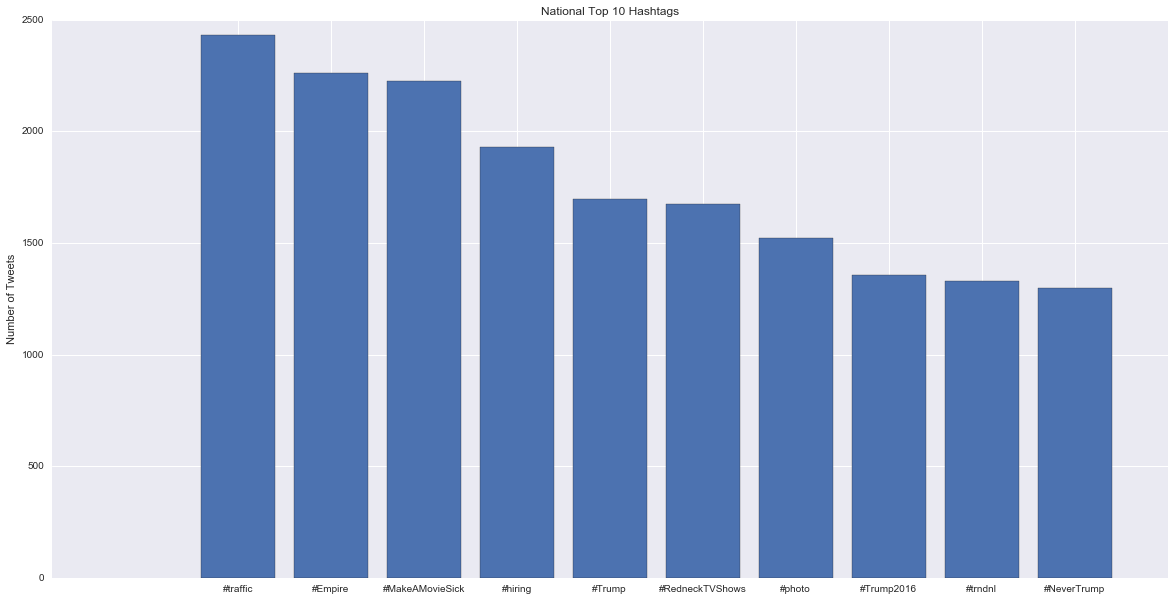

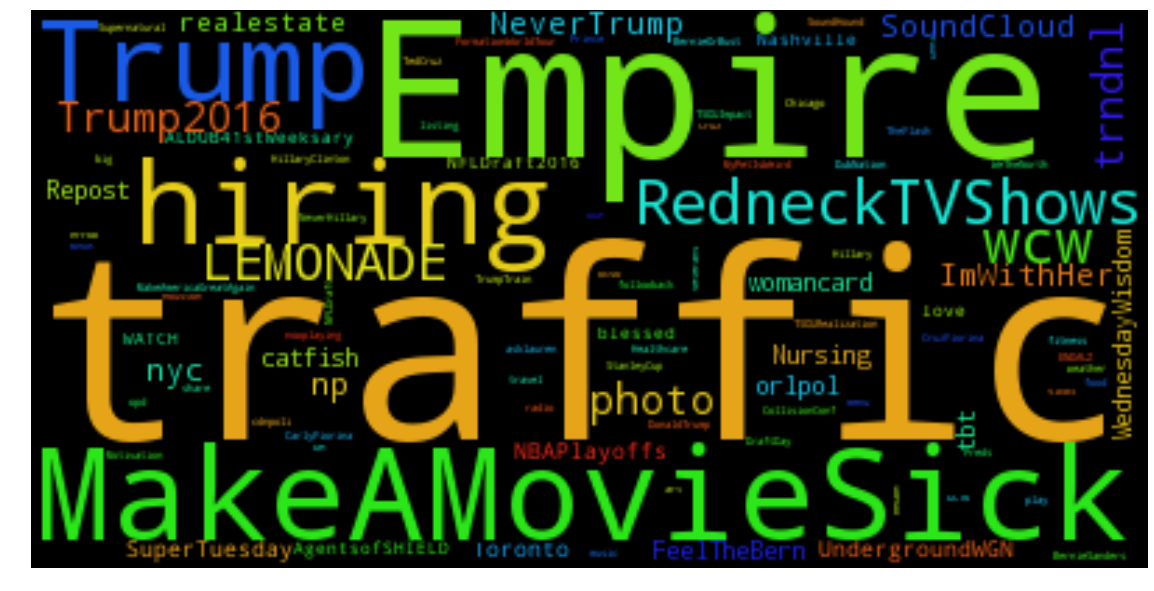

In [455]:
count_rand = count_terms(rand_smpl)
datums = count_rand.most_common(10)
#Sort the datums with most common first
datums.sort(key=lambda x: x[1], reverse=True)       
#create the ordered list of hashtags for axis labeling
hashtag = list(zip(*datums))[0]
    
#zip up the data for the match and original hashtag scores into arrays
score = list(zip(*datums))[1]

#arrange the hashtags in order
x_pos = np.arange(len(hashtag))

#put local and national data into a pandas data frame
plt.figure(figsize=(20, 10))
plt.bar(x_pos,score,align='center')
plt.xticks(x_pos, hashtag)
plt.title("National Top 10 Hashtags")
plt.ylabel('Number of Tweets')

word_cloud(count_rand)

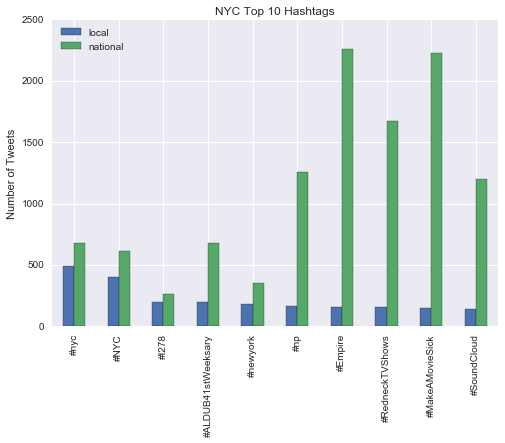

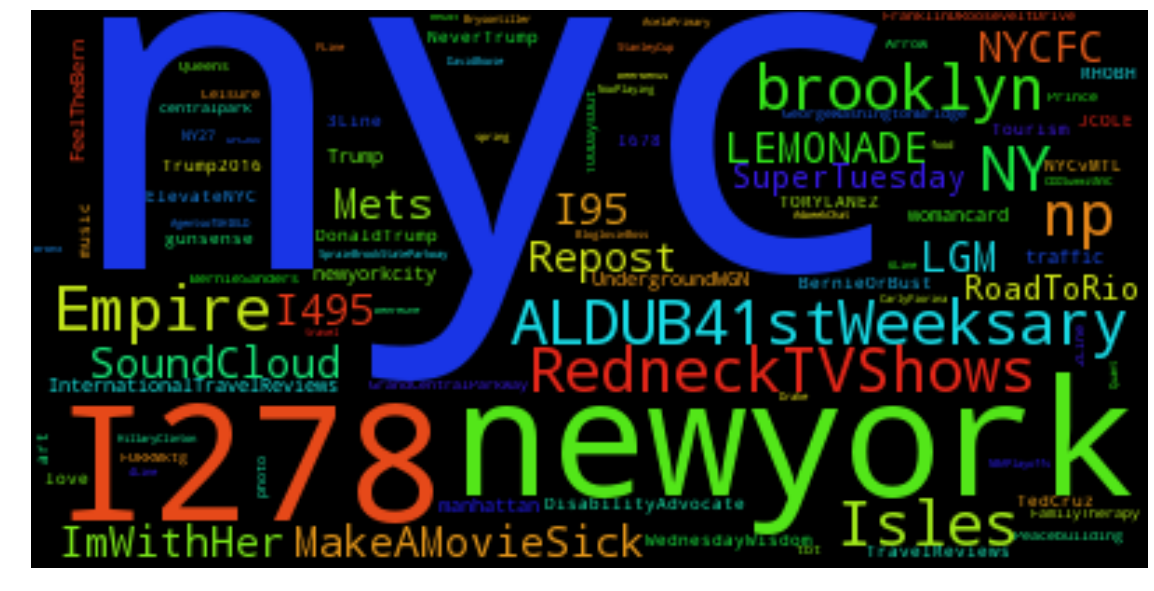

In [456]:
count_nyc = count_terms(nyc_geo_data)
plot_bar(count_nyc,count_rand,"NYC Top 10 Hashtags")
word_cloud(count_nyc)

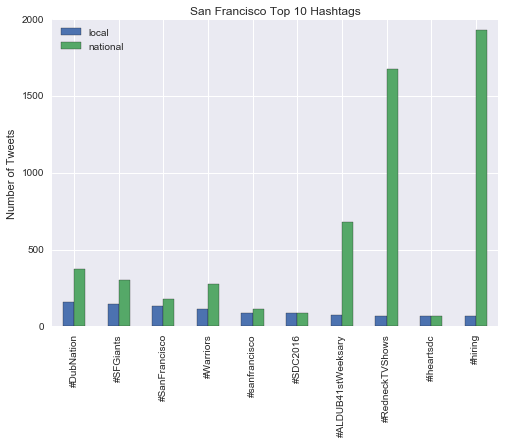

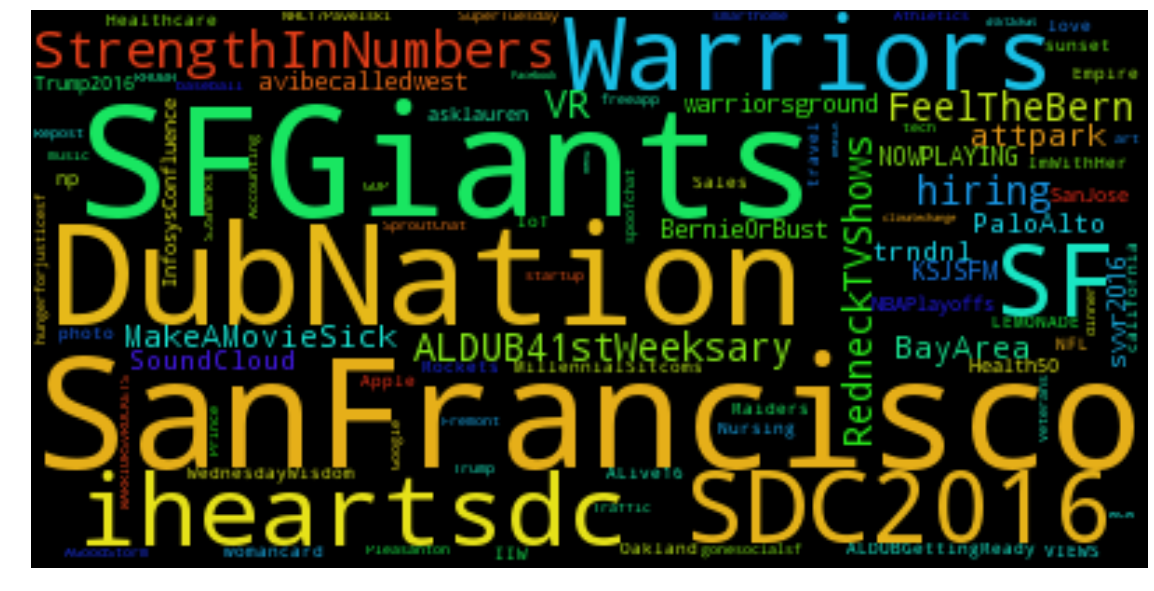

In [457]:
count_sf = count_terms(sf_geo_data)
plot_bar(count_sf,count_rand,"San Francisco Top 10 Hashtags")
word_cloud(count_sf)

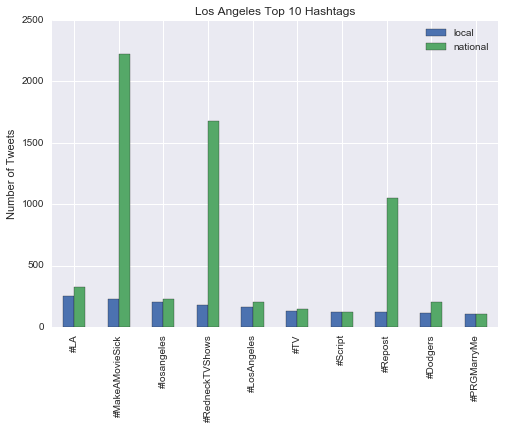

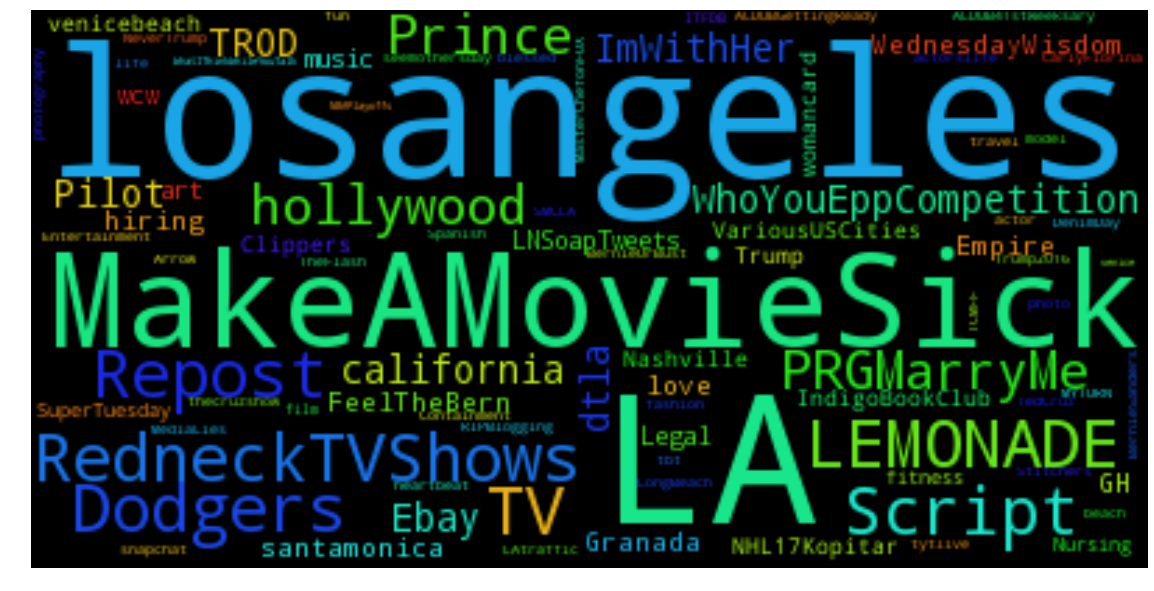

In [458]:
count_la = count_terms(la_geo_data)
plot_bar(count_la,count_rand,"Los Angeles Top 10 Hashtags")
word_cloud(count_la)

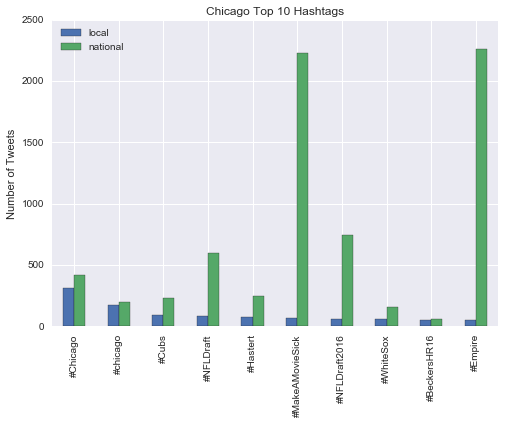

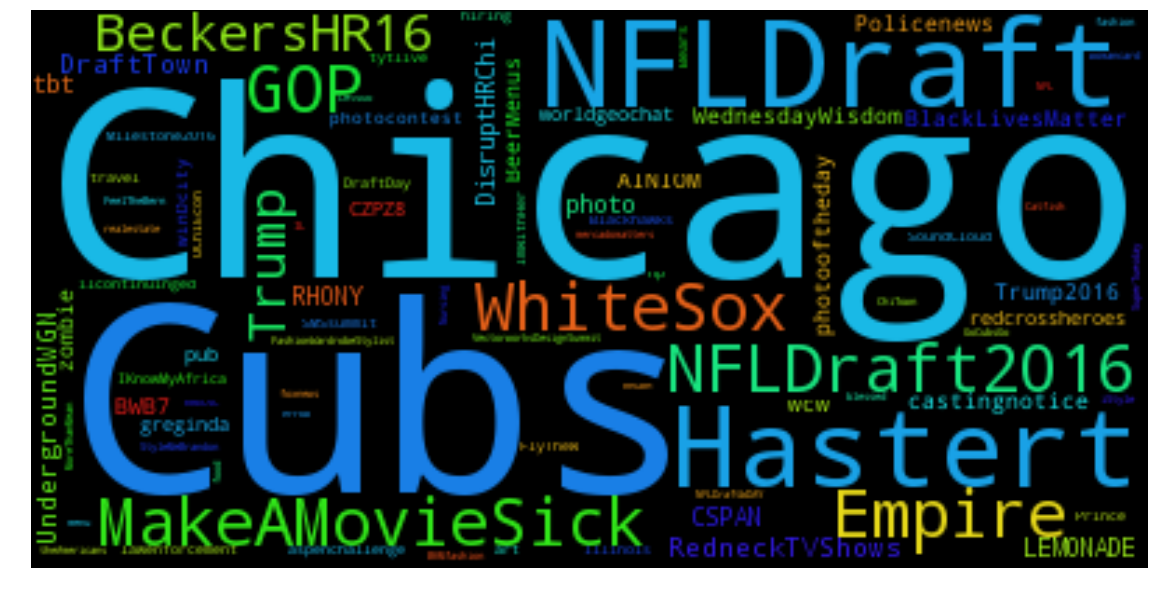

In [460]:
count_ch = count_terms(ch_geo_data)
plot_bar(count_ch,count_rand,"Chicago Top 10 Hashtags")
word_cloud(count_ch)

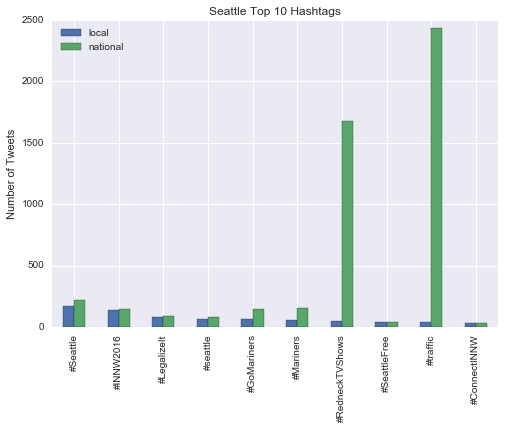

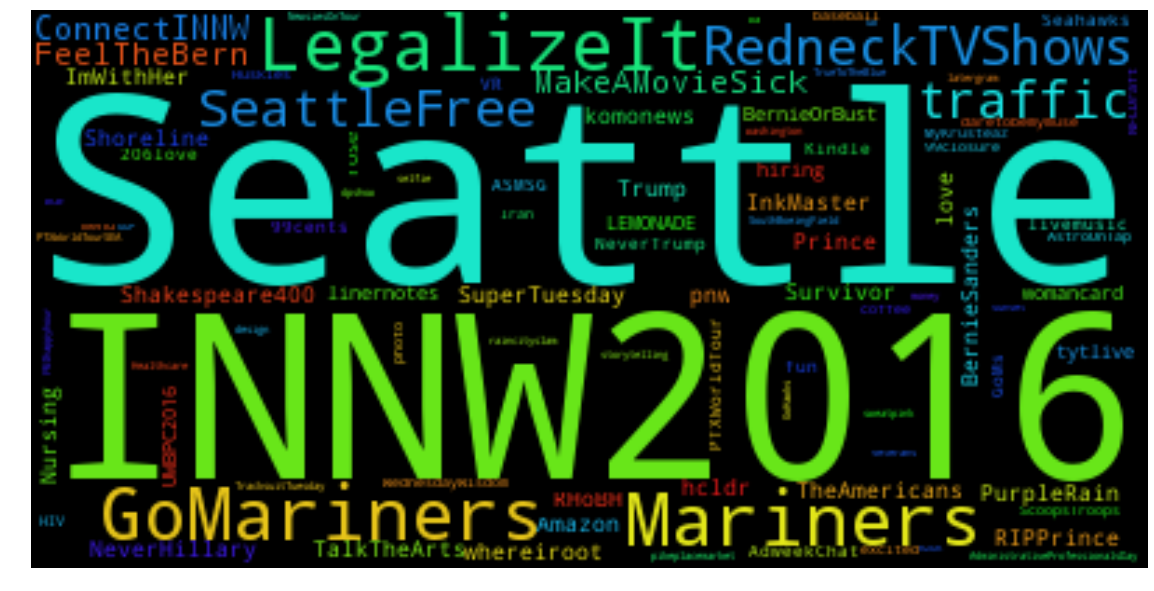

In [461]:
count_sea = count_terms(sea_geo_data)
plot_bar(count_sea,count_rand,"Seattle Top 10 Hashtags")
word_cloud(count_sea)

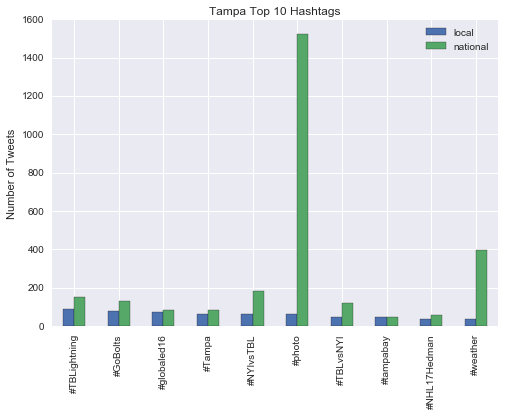

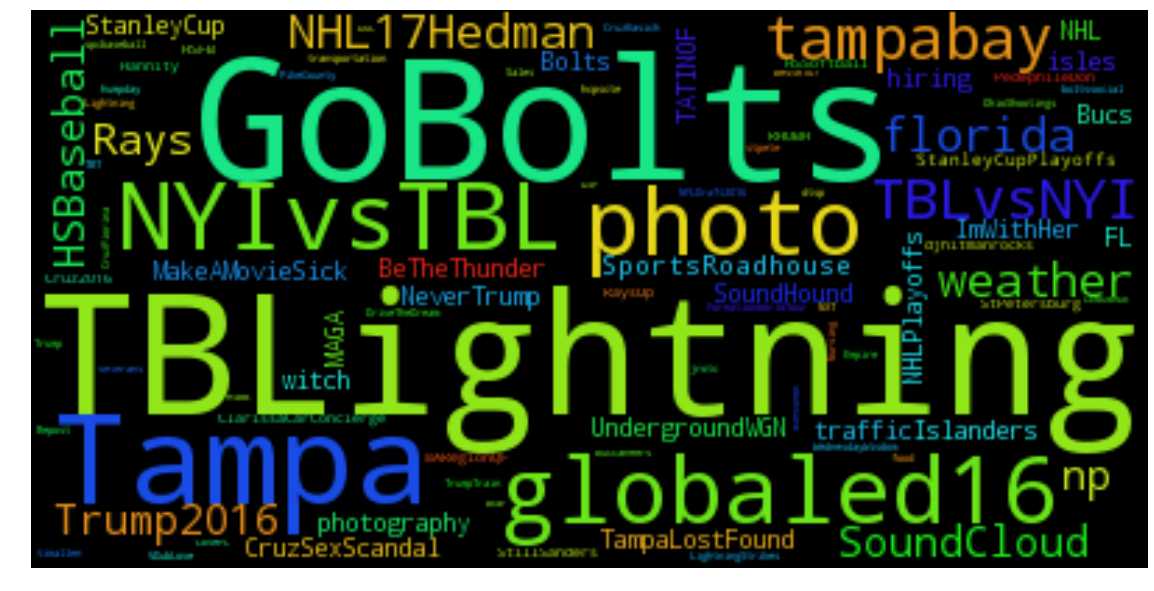

In [462]:
count_tamp = count_terms(tamp_geo_data)
plot_bar(count_tamp,count_rand,"Tampa Top 10 Hashtags")
word_cloud(count_tamp)

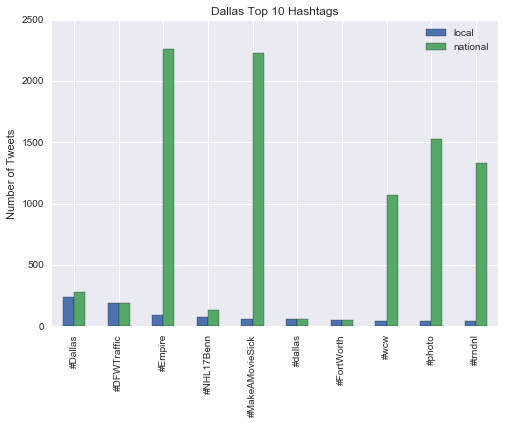

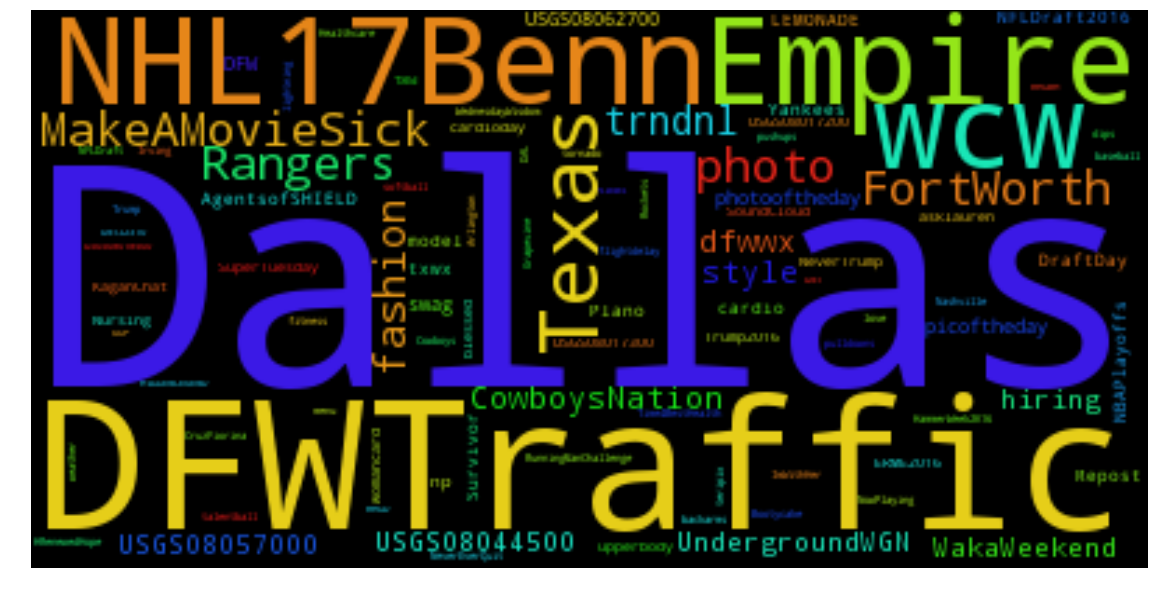

In [463]:
count_dallas = count_terms(dallas_geo_data)
plot_bar(count_dallas,count_rand,"Dallas Top 10 Hashtags")
word_cloud(count_dallas)

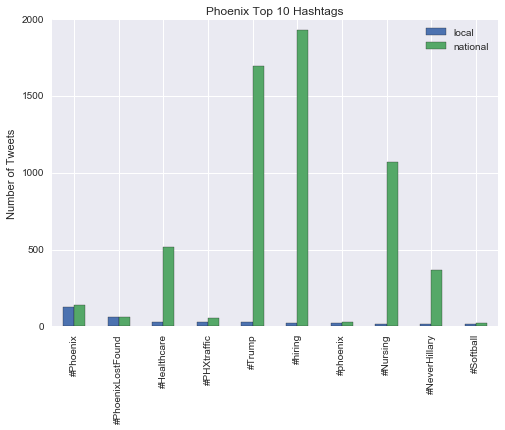

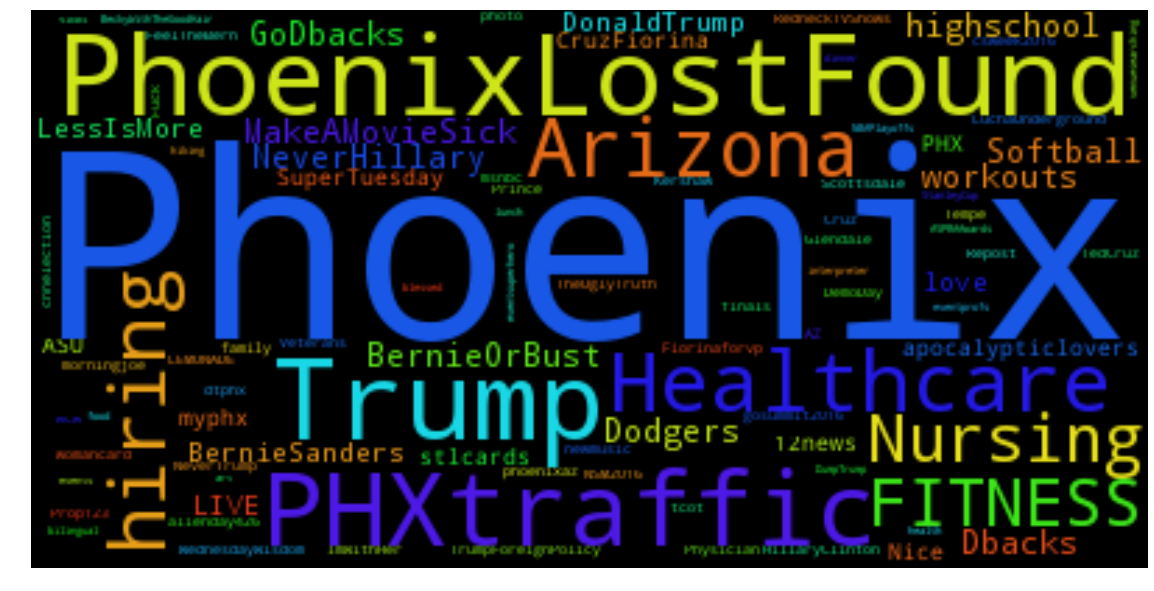

In [464]:
count_phoenix = count_terms(phoenix_geo_data)
plot_bar(count_phoenix,count_rand,"Phoenix Top 10 Hashtags")
word_cloud(count_phoenix)

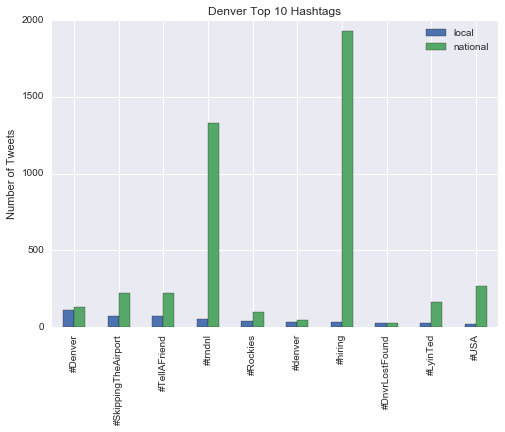

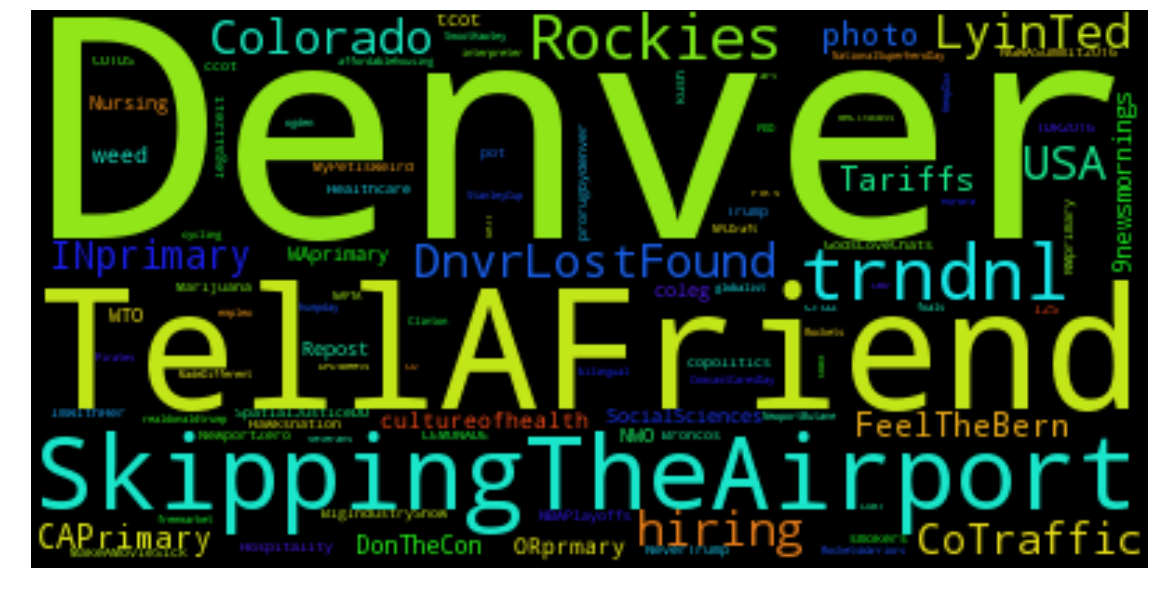

In [465]:
count_denver = count_terms(denver_geo_data)
plot_bar(count_denver,count_rand,"Denver Top 10 Hashtags")
word_cloud(count_denver)

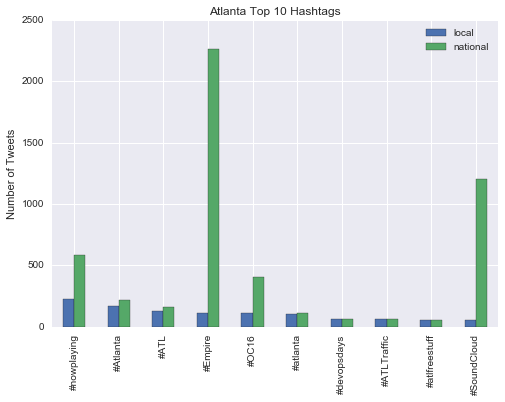

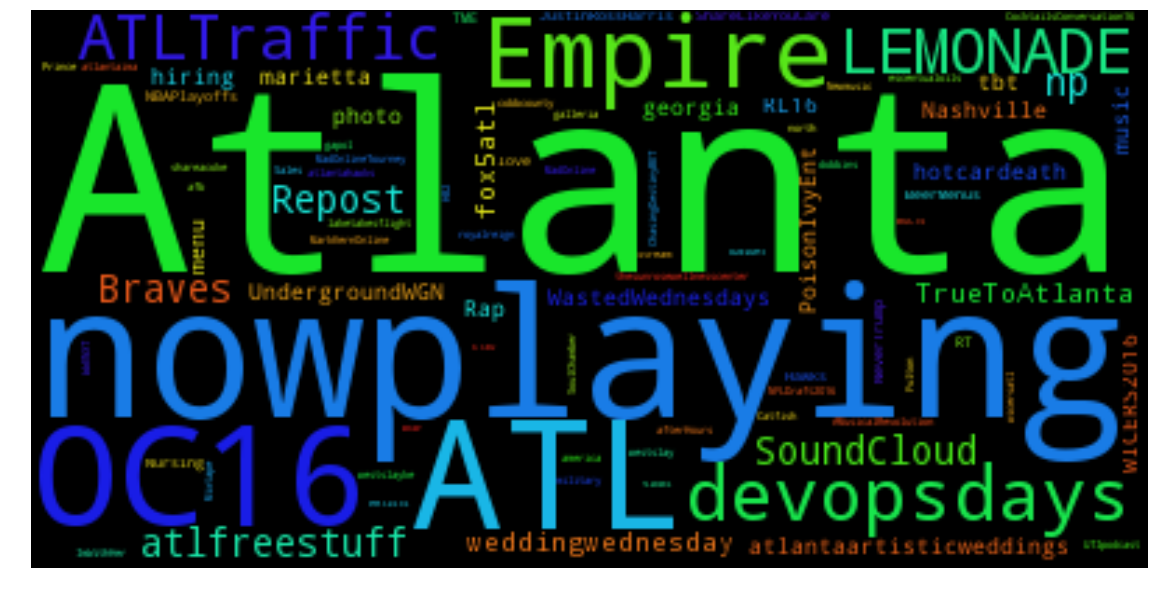

In [466]:
count_atlanta = count_terms(atlanta_geo_data)
plot_bar(count_atlanta,count_rand,"Atlanta Top 10 Hashtags")
word_cloud(count_atlanta)

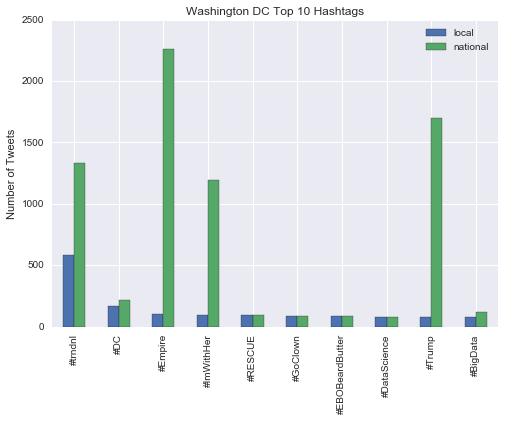

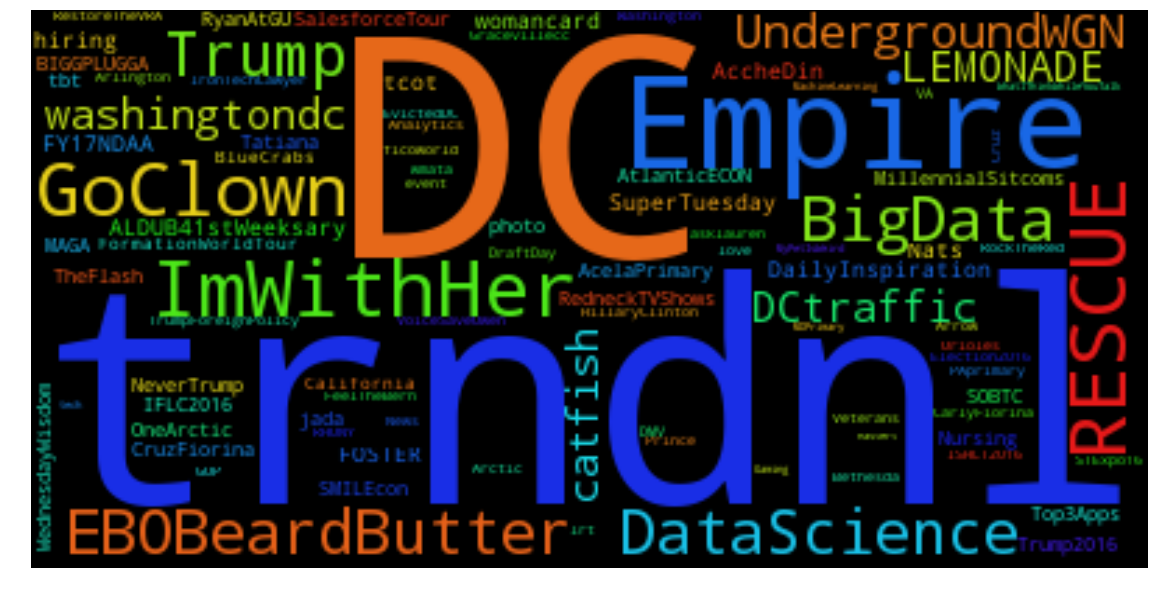

In [467]:
count_dc = count_terms(dc_geo_data)
plot_bar(count_dc,count_rand,"Washington DC Top 10 Hashtags")
word_cloud(count_dc)

## Explore the geo data using Alchemy Sentiment Analysis and Twitter Rest API
Here we explore the effect of Tweet location on Tweet interactions. We use the Twitter Rest API to get the favorite and retweet counts of the tweets. We define an interaction metric as simply # of likes + # of retweets. Then we look at the average number of interactions per examined area. Here we are only examining tweets that contain the hashtag Trump or Trump2016. This work has not progressed as far as I wanted it to because I am only allowed to call the rest api 60 times ever 15 minuites, while I have thousands of tweets to look through.

In [174]:
def load_keys():
    """
    Loads the API keys for the twitter REST API
    """
    keys = []
    path = os.path.join('.keys')
    f = open(path, 'r')
    for line in f:
        keys.append(str(line).replace('\n',''))
    return keys

In [175]:
#use twython to create a rest api client
keys = load_keys()
twitter = Twython(keys[0], keys[1],
                  keys[2], keys[3])

In [397]:
#filter different geo arays so that the array filtered only contains tweets with #trump2016 or #trump
filtered = []
for d in rand_smpl:
    if "#Trump2016" in d['text'] or "#Trump" in d['text']:
        filtered.append(d)

#if we have greater than 60 tweets, take a random sample and use that instead
try:
    filtered = rand_sample(60, filtered)
except Exception:
    pass

ave = 0
t_count = 0
c = 0

#iterate though the tweets and add up the retweet and favorite counts
while c < len(filtered):
    try:
        rt = twitter.get_retweets(id=filtered[c]['id'])
        if len(rt) > 0 and rt[0]['retweet_count'] < 10 and rt[0]['favorite_count'] < 10:
            t_count += 1
            ave += rt[0]['retweet_count'] + rt[0]['favorite_count']
        else:
            pass
        c += 1
    except Exception:
        #If we are out of calls then wait until we have calls again
        if twitter.get_application_rate_limit_status()['resources']['statuses']['/statuses/retweets/:id']['remaining'] == 0:
            print("RATE EXCEEDED")
            re_time = twitter.get_application_rate_limit_status()['resources']['statuses']['/statuses/retweets/:id']['reset']
            curr_time = time.time()
            time.sleep(re_time - curr_time + 5)
        else:
            print("Other Error")
            c += 1
            pass
        
#log the average number of interactions
print(ave/t_count)

2.3076923076923075


In [330]:
#helper function to see how many calls I have left
twitter.get_application_rate_limit_status()['resources']['statuses']['/statuses/retweets/:id']

{'limit': 60, 'remaining': 0, 'reset': 1462119115}

## Use Alchemy to obtain an average tweet sentiment
Now we use the Alchemy API to get the average tweet sentiment score for each geo location. I would like to spend more time proprocessing the data set to get better sentiment results, however that is a hard and very arbitrary problem, so for now I send the tweets in with minimal filtering.

In [386]:
#filter the geo data for tweets containing the target hashtag
filtered = []
for d in tamp_geo_data:
    if "#Trump2016" in d['text'] or "#Trump" in d['text']:
        filtered.append(d)
print(len(filtered))

48


In [400]:
#Obtain the average tweet sentiment score for the filtered array
text = []
sentiment = []
s = ""
for d in filtered:
    cleaned = p.clean(d['text'].lower())
    response = alchemyapi.sentiment('text',cleaned)
#     s += cleaned + " "
#     text.append(cleaned)
    if response['status'] != 'OK':
        break
    if response['docSentiment']['type'] == 'neutral':
        sentiment.append(0)
    else:
        sentiment.append(float(response['docSentiment']['score']))
ave = np.mean(np.array(sentiment))
print(ave)

nan


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


## Aggregate the Interaction Rates and Sentiment Scores and Vizualize Them
Because of the limits of the rest api, I had to run the code separatly for each of the geo locations. Below I take the data and put it into a pandas dataframe for later use.

In [398]:
#[average retweet rates,sentiment score]
Chicago = [2.7142857142857144, 0.0672747]
Tampa = [2.7142857142857144, -0.107008]
NYC = [2.0714285714285716, 0.0666163]
SF = [2.25, -0.351972]
Phoenix = [2.0625,0.000326956]
Denver = [3.0,-0.562185]
Atlanta = [1.2,0.0837211]
DC = [1.8333333333333333,-0.0416102]
Dallas = [3.0714285714285716,0.0199777]
LA = [1.9230769230769231,0.0681025]
sea = [2.4,-0.164262] #no positive tweets
national = [2.3076923076923075,0.128462]

locations = ["Chicago", "Tampa", "NYC", "SF", "Phoenix", "Denver", "Atlanta", "DC", "Dallas", "LA", "Seattle", "National"]

retweet_fav = [2.7142857142857144,2.7142857142857144,2.0714285714285716,
               2.25,2.0625,3.0,1.2,1.8333333333333333,3.0714285714285716,
               1.9230769230769231,2.4,2.3076923076923075]
sentiment_score = [0.0672747,-0.107008,0.0666163,-0.351972,0.000326956,
                   -0.562185,0.0837211,-0.0416102,0.0199777,0.0681025,
                  -0.164262,0.128462]
primary_rates = [0.47,0.464,0.418,0.41,0.462,0.36,0.266,0.13,0.248,0,0,0.418]

print(len(retweet_fav),len(sentiment_score),len(primary_rates))
data = {'locations': locations,
        'retweet' : retweet_fav,
        'sentiment':sentiment_score,
        'primary':primary_rates}

df = pd.DataFrame(data, columns=['locations', 'retweet', 'sentiment','primary'])
print(df)

12 12 12
   locations   retweet  sentiment  primary
0    Chicago  2.714286   0.067275    0.470
1      Tampa  2.714286  -0.107008    0.464
2        NYC  2.071429   0.066616    0.418
3         SF  2.250000  -0.351972    0.410
4    Phoenix  2.062500   0.000327    0.462
5     Denver  3.000000  -0.562185    0.360
6    Atlanta  1.200000   0.083721    0.266
7         DC  1.833333  -0.041610    0.130
8     Dallas  3.071429   0.019978    0.248
9         LA  1.923077   0.068102    0.000
10   Seattle  2.400000  -0.164262    0.000
11  National  2.307692   0.128462    0.418


## Plot number of Tweet Interactions By Geo Location
Here it becomes clear that the number of retweets you get on you tweet is highly variable based on where you tweeted from.

([<matplotlib.axis.XTick at 0x2e463c128>,
 <a list of 12 Text xticklabel objects>)

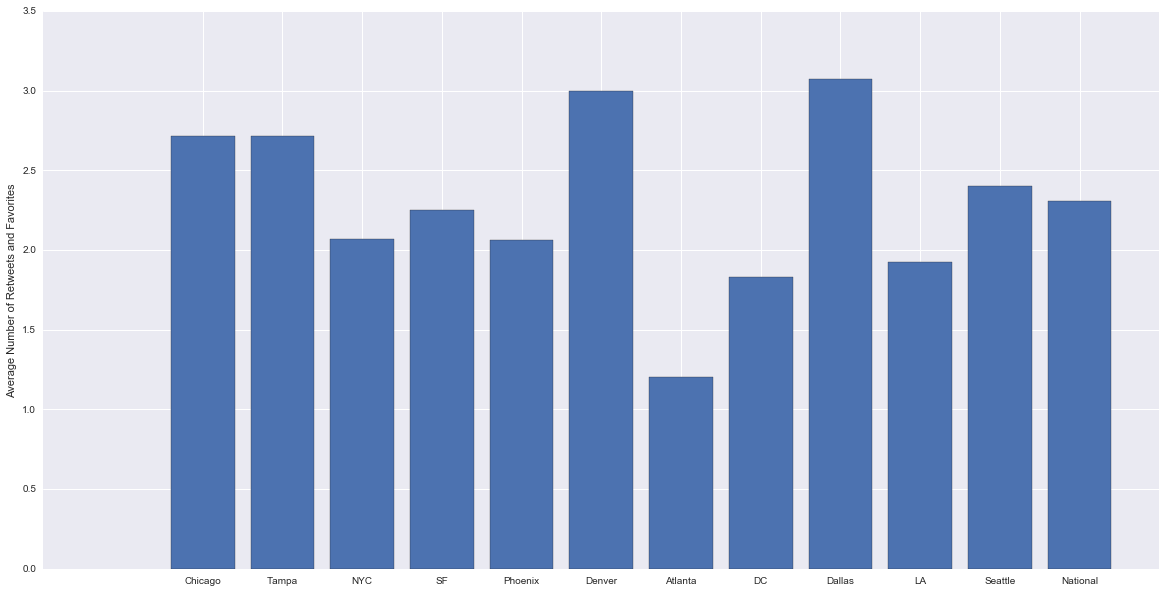

In [403]:
plt.figure(figsize=(20,10))
plt.bar(range(12), df.retweet, align='center') 
plt.ylabel("Average Number of Retweets and Favorites")
plt.xticks(range(12), df.locations)

## Graph each Geo Location by Average Interactions and Sentiment
Here we see that the more negative the tweet is, the more interactions it gets. This hints that people respond most often to radical negative ideas

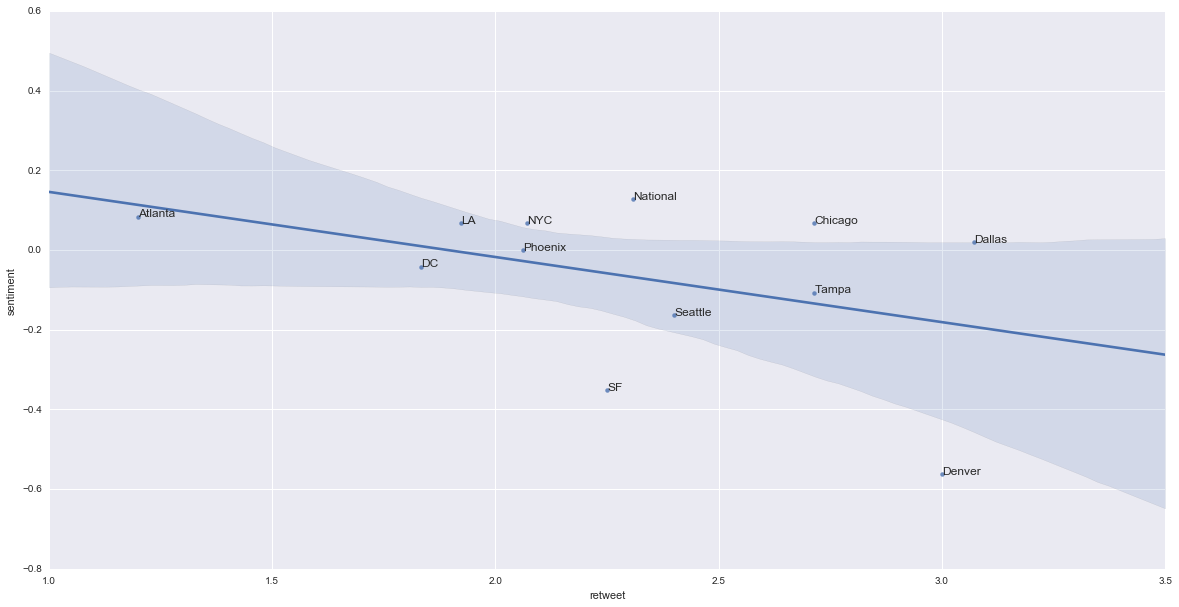

In [468]:
# x = retweet_fav
# y = sentiment_score

plt.figure(figsize=(20,10))
sns.regplot(x='retweet', y='sentiment', data=df)
for i, txt in enumerate(df.locations):
    plt.annotate(txt, (df.retweet[i],df.sentiment[i]))


In [173]:
filtered = []
for d in rand_smpl:
    if "#Trump2016" in d['text']:
        filtered.append(d)
print(len(filtered))

31


In [ ]:
to_json(filtered)

In [ ]:
# dates = []
# eastern = pytz.timezone('US/Eastern')
# for d in filtered:
#     dates.append(d['created_at'])
# ones = [1]*len(dates)
# idx = pd.DatetimeIndex(dates).tz_localize(pytz.utc).tz_convert(eastern)
# dates_series = pd.Series(ones, index=idx)
# # Resampling / bucketing
# per_minuite = dates_series.resample('1Min', how='sum').fillna(0)

In [ ]:
# time_chart = vincent.Line(per_minuite)
# time_chart.axis_titles(x='Time', y='Freq')